<a href="https://colab.research.google.com/github/Sanyam-Jain1/Lunar-DEM-generation/blob/main/DEM_generation_and_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


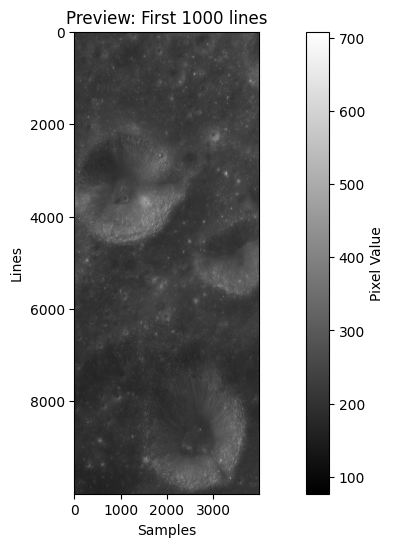

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

filename = '/content/drive/MyDrive/preview/ch2_tmc_ncn_20200722T0439298494_d_img_d32.img'

lines = 234333
samples = 4000
dtype = np.uint16  # UnsignedLSB2 ≈ unsigned 16-bit little-endian

# Open the file and read only a subset (e.g., first 1000 lines)
num_preview_lines = 10000

with open(filename, 'rb') as f:
    data = np.fromfile(f, dtype='<u2', count=num_preview_lines * samples)
    # '<u2': little-endian unsigned short (16-bit)

# Reshape to 2D
image_preview = data.reshape((num_preview_lines, samples))

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(image_preview, cmap='gray')
plt.title("Preview: First 1000 lines")
plt.xlabel("Samples")
plt.ylabel("Lines")
plt.colorbar(label='Pixel Value')
plt.show()


✅ Image loaded: (4000, 4000)
✅ Noise reduction done
✅ Illumination correction done
✅ Contrast enhancement done


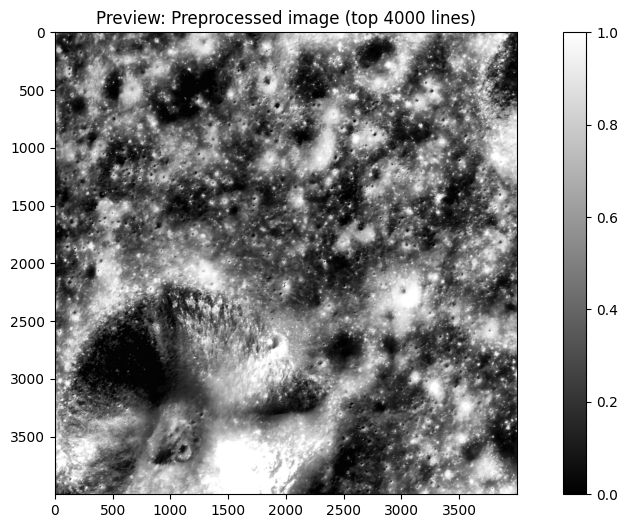

✅ Saved: /content/preprocessed_thumbnail.png


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# === Parameters from your XML metadata ===
img_shape = (234333, 4000)
sun_elevation = 64.821874  # degrees
sun_azimuth = 318.770477   # degrees
pixel_resolution = 4.84    # m/pixel

# === Step 1: Load TMC image from raw binary ===
img_file = '/content/drive/MyDrive/preview/ch2_tmc_ncn_20200722T0439298494_d_img_d32.img'

# Process only top N lines for preview to save memory
N = 4000  # adjust as needed
with open(img_file, 'rb') as f:
    img = np.fromfile(f, dtype='<u2', count=N*img_shape[1]).reshape((N, img_shape[1]))

print("✅ Image loaded:", img.shape)

# === Step 2: Noise reduction ===
# Robust min-max to avoid outliers
img_min, img_max = np.percentile(img, [2, 98])
img8 = ((np.clip(img, img_min, img_max) - img_min) / (img_max - img_min) * 255).astype(np.uint8)

# fastNlMeansDenoising
denoised8 = cv2.fastNlMeansDenoising(img8, None, h=10, templateWindowSize=7, searchWindowSize=21)

# Back to float32 scaled
denoised = denoised8.astype(np.float32) / 255.0 * (img_max - img_min) + img_min

print("✅ Noise reduction done")

# === Step 3: Illumination correction ===
incidence_angle = 90 - sun_elevation   # ≈25.18°
incidence_rad = np.deg2rad(incidence_angle)
cos_i = np.cos(incidence_rad)

illum_corrected = denoised / cos_i
illum_corrected = np.clip(illum_corrected, 0, np.percentile(illum_corrected, 99))

print("✅ Illumination correction done")

# === Step 4: Contrast enhancement (CLAHE) ===
ic_min, ic_max = np.percentile(illum_corrected, [2, 98])
illum8 = ((np.clip(illum_corrected, ic_min, ic_max) - ic_min) / (ic_max - ic_min) * 255).astype(np.uint8)

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
enhanced8 = clahe.apply(illum8)

enhanced = enhanced8.astype(np.float32) / 255.0

print("✅ Contrast enhancement done")

# === Step 5: Quick preview ===
preview = enhanced[:10000, :]  # first 4000 lines

plt.figure(figsize=(12,6))
plt.imshow(preview, cmap='gray')
plt.title('Preview: Preprocessed image (top 4000 lines)')
plt.colorbar()
plt.show()

# === Step 6: Save thumbnail for DEM or shape-from-shading later ===
thumbnail = cv2.resize(enhanced, (4000, 200), interpolation=cv2.INTER_AREA)
plt.imsave('/content/preprocessed_thumbnail.png', thumbnail, cmap='gray')

print("✅ Saved: /content/preprocessed_thumbnail.png")


✅ Image loaded: (10000, 4000)
✅ Preprocessing done
✅ DEM saved: /content/output_dem.png


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127769 (\N{CRESCENT MOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127769 (\N{CRESCENT MOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


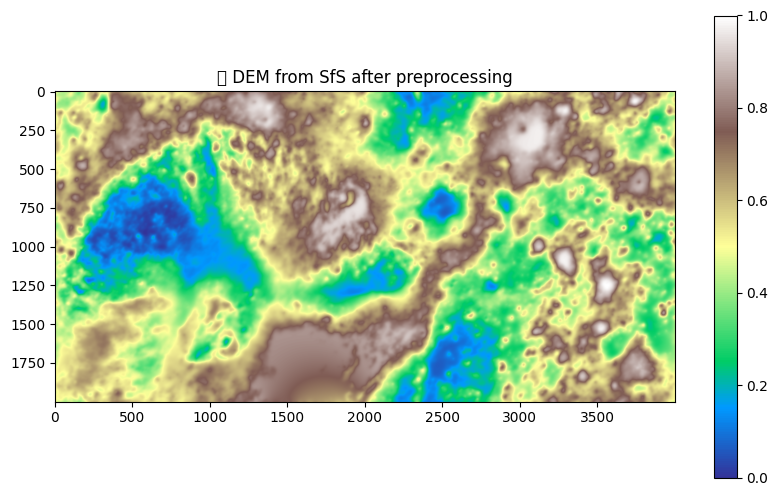

In [ ]:
"import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft2, ifft2, fftfreq

# -------------------- CLASSICAL SFS --------------------
def lambertian_shade(normals, light_dir, albedo=1.0):
    return albedo * np.clip(np.sum(normals * light_dir.reshape(1, 1, 3), axis=2), 0, 1)

def classical_sfs(I, light_dir, albedo=1.0, iters=300, lr=0.1, smooth_sigma=1.0):
    H, W = I.shape
    Z = np.zeros((H, W), dtype=np.float32)
    for _ in range(iters):
        p = np.gradient(Z, axis=1)
        q = np.gradient(Z, axis=0)

        Nx = -p
        Ny = -q
        Nz = np.ones_like(Z)

        norm = np.sqrt(Nx**2 + Ny**2 + Nz**2 + 1e-8)
        Nx /= norm
        Ny /= norm
        Nz /= norm

        normals = np.dstack((Nx, Ny, Nz))
        I_pred = lambertian_shade(normals, light_dir, albedo)
        diff = I - I_pred

        diff_smoothed = gaussian_filter(diff, sigma=smooth_sigma)
        Z += lr * diff_smoothed

        Z = gaussian_filter(Z, sigma=smooth_sigma)

    return Z

# -------------------- NORMAL INTEGRATION --------------------
def frankot_chellappa(p, q):
    H, W = p.shape
    wx = fftfreq(W).reshape(1, -1)
    wy = fftfreq(H).reshape(-1, 1)
    WX, WY = np.meshgrid(wx, wy)
    denom = WX**2 + WY**2
    denom[denom == 0] = 1e-8

    p_fft = fft2(p)
    q_fft = fft2(q)

    Z_fft = (-1j * WX * p_fft - 1j * WY * q_fft) / denom
    Z = np.real(ifft2(Z_fft))
    return Z

# -------------------- MAIN --------------------
if __name__ == "__main__":
    # === NEW metadata ===
    img_shape = (234333, 4000)
    sun_elevation = 64.821874  # degrees
    sun_azimuth = 318.770477   # degrees

    # Process only top N lines for speed
    N = 4000

    img_file = '/content/drive/MyDrive/preview/ch2_tmc_ncn_20200722T0439298494_d_img_d32.img'

    # === Step 1: Load partial image ===
    N = 10000  # adjust as needed
    with open(img_file, 'rb') as f:
        img = np.fromfile(f, dtype='<u2', count=N*img_shape[1]).reshape((N, img_shape[1]))

    print("✅ Image loaded:", img.shape)

    # === Step 2: Earlier preprocessing ===
    # a) Noise reduction
    img_min, img_max = np.percentile(img, [2, 98])
    img8 = ((np.clip(img, img_min, img_max) - img_min) / (img_max - img_min) * 255).astype(np.uint8)
    denoised8 = cv2.fastNlMeansDenoising(img8, None, h=10, templateWindowSize=7, searchWindowSize=21)
    denoised = denoised8.astype(np.float32) / 255.0 * (img_max - img_min) + img_min

    # b) Illumination correction
    incidence_angle = 90 - sun_elevation
    cos_i = np.cos(np.deg2rad(incidence_angle))
    illum_corrected = denoised / cos_i
    illum_corrected = np.clip(illum_corrected, 0, np.percentile(illum_corrected, 99))

    # c) Contrast enhancement (CLAHE)
    ic_min, ic_max = np.percentile(illum_corrected, [2, 98])
    illum8 = ((np.clip(illum_corrected, ic_min, ic_max) - ic_min) / (ic_max - ic_min) * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced8 = clahe.apply(illum8)
    enhanced = enhanced8.astype(np.float32) / 255.0
    print("✅ Preprocessing done")

    # === Step 3: DEM generation with SfS ===
    # Convert sun angles to light vector
    az_rad = np.deg2rad(sun_azimuth)
    el_rad = np.deg2rad(sun_elevation)
    light_vector = np.array([
        np.cos(el_rad) * np.cos(az_rad),
        np.cos(el_rad) * np.sin(az_rad),
        np.sin(el_rad)
    ])

    # Use small top block for DEM
    small_block = enhanced[3000:4000, :]

    classical_dem = classical_sfs(small_block, light_vector)

    # Compute gradients and refine
    p = np.gradient(classical_dem, axis=1)
    q = np.gradient(classical_dem, axis=0)
    refined_dem = frankot_chellappa(p, q)

    # Normalize & save
    refined_dem -= np.min(refined_dem)
    refined_dem /= (np.max(refined_dem) + 1e-8)
    dem_img = (refined_dem * 255).astype(np.uint8)
    cv2.imwrite('/content/output_dem.png', dem_img)

    print("✅ DEM saved: /content/output_dem.png")

    # Optional view
    plt.figure(figsize=(10,6))
    plt.imshow(refined_dem, cmap='terrain')
    plt.title('🌙 DEM from SfS after preprocessing')
    plt.colorbar()
    plt.show()


In [ ]:
import os
img_file = '/content/drive/MyDrive/preview/ch2_tmc_ncn_20200722T0439298494_d_img_d32.img'
print("File size (bytes):", os.path.getsize(img_file))


File size (bytes): 1574592000


✅ Loaded image: (10000, 4000)
✅ Preprocessing complete
✅ DEM saved: /content/output_dem.png


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127769 (\N{CRESCENT MOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127769 (\N{CRESCENT MOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127769 (\N{CRESCENT MOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


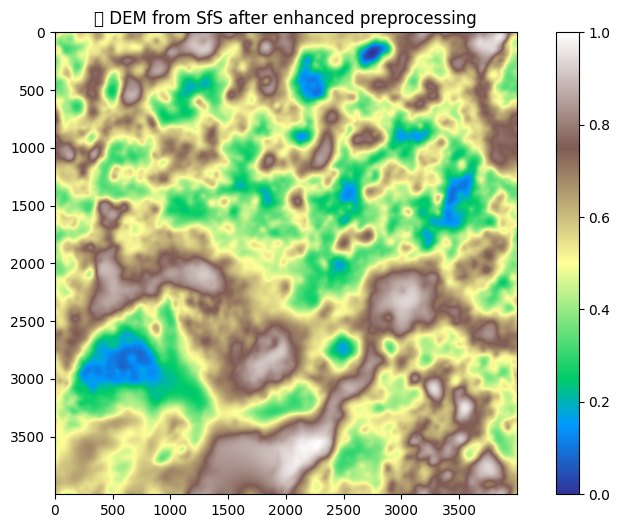

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft2, ifft2, fftfreq

# -------------------- CLASSICAL SFS --------------------
def lambertian_shade(normals, light_dir, albedo=1.0):
    """Compute Lambertian shading"""
    return albedo * np.clip(np.sum(normals * light_dir.reshape(1, 1, 3), axis=2), 0, 1)

def classical_sfs(I, light_dir, albedo=1.0, iters=500, lr=0.1, smooth_sigma=2.0):
    """Simple shape-from-shading using gradient descent and smoothing"""
    H, W = I.shape
    Z = np.zeros((H, W), dtype=np.float32)
    for _ in range(iters):
        p = np.gradient(Z, axis=1)
        q = np.gradient(Z, axis=0)

        Nx = -p
        Ny = -q
        Nz = np.ones_like(Z)

        norm = np.sqrt(Nx**2 + Ny**2 + Nz**2 + 1e-8)
        Nx /= norm
        Ny /= norm
        Nz /= norm

        normals = np.dstack((Nx, Ny, Nz))
        I_pred = lambertian_shade(normals, light_dir, albedo)
        diff = I - I_pred

        diff_smoothed = gaussian_filter(diff, sigma=smooth_sigma)
        Z += lr * diff_smoothed

        Z = gaussian_filter(Z, sigma=smooth_sigma)

    return Z

# -------------------- NORMAL INTEGRATION --------------------
def frankot_chellappa(p, q):
    """Integrate gradients to height map"""
    H, W = p.shape
    wx = fftfreq(W).reshape(1, -1)
    wy = fftfreq(H).reshape(-1, 1)
    WX, WY = np.meshgrid(wx, wy)
    denom = WX**2 + WY**2
    denom[denom == 0] = 1e-8

    p_fft = fft2(p)
    q_fft = fft2(q)

    Z_fft = (-1j * WX * p_fft - 1j * WY * q_fft) / denom
    Z = np.real(ifft2(Z_fft))
    return Z

# -------------------- MAIN --------------------
if __name__ == "__main__":
    # === Metadata ===
    img_shape = (234333, 4000)
    sun_elevation = 64.821874  # degrees
    sun_azimuth = 318.770477   # degrees

    # Number of top lines to process
    N = 10000

    img_file = '/content/drive/MyDrive/preview/ch2_tmc_ncn_20200722T0439298494_d_img_d32.img'

    # === Step 1: Load partial image ===
    with open(img_file, 'rb') as f:
        img = np.fromfile(f, dtype='<u2', count=N*img_shape[1]).reshape((N, img_shape[1]))
    print("✅ Loaded image:", img.shape)

    # === Step 2: Preprocessing ===
    # a) Robust contrast stretch & noise reduction
    img_min, img_max = np.percentile(img, [2, 98])
    img8 = ((np.clip(img, img_min, img_max) - img_min) / (img_max - img_min) * 255).astype(np.uint8)
    denoised8 = cv2.fastNlMeansDenoising(img8, None, h=10, templateWindowSize=7, searchWindowSize=21)
    denoised = denoised8.astype(np.float32) / 255.0 * (img_max - img_min) + img_min

    # b) Illumination correction
    incidence_angle = 90 - sun_elevation
    cos_i = np.cos(np.deg2rad(incidence_angle))
    illum_corrected = denoised / cos_i
    illum_corrected = np.clip(illum_corrected, 0, np.percentile(illum_corrected, 99))

    # c) Contrast enhancement with CLAHE
    ic_min, ic_max = np.percentile(illum_corrected, [2, 98])
    illum8 = ((np.clip(illum_corrected, ic_min, ic_max) - ic_min) / (ic_max - ic_min) * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced8 = clahe.apply(illum8)
    enhanced = enhanced8.astype(np.float32) / 255.0

    # d) Log intensity to compress bright/dark variation
    log_enhanced = np.log1p(enhanced)
    log_enhanced -= np.min(log_enhanced)
    log_enhanced /= (np.max(log_enhanced) + 1e-8)

    print("✅ Preprocessing complete")

    # === Step 3: DEM generation ===
    # Convert sun angles to light vector
    az_rad = np.deg2rad(sun_azimuth)
    el_rad = np.deg2rad(sun_elevation)
    light_vector = np.array([
        np.cos(el_rad) * np.cos(az_rad),
        np.cos(el_rad) * np.sin(az_rad),
        np.sin(el_rad)
    ])

    # Use smaller top block (for speed)
    small_block = log_enhanced[:4000, :]

    # SfS with smoother & more iterations
    classical_dem = classical_sfs(
        small_block, light_vector,
        iters=500, lr=0.1, smooth_sigma=2.0
    )

    # Gradient integration to smooth shape
    p = np.gradient(classical_dem, axis=1)
    q = np.gradient(classical_dem, axis=0)
    refined_dem = frankot_chellappa(p, q)

    # Optional smoothing to reduce high-frequency noise
    refined_dem = gaussian_filter(refined_dem, sigma=1.0)

    # Normalize
    refined_dem -= np.min(refined_dem)
    refined_dem /= (np.max(refined_dem) + 1e-8)

    # Save DEM image
    dem_img = (refined_dem * 255).astype(np.uint8)
    cv2.imwrite('/content/output_dem.png', dem_img)
    print("✅ DEM saved: /content/output_dem.png")

    # Preview
    plt.figure(figsize=(10,6))
    plt.imshow(refined_dem, cmap='terrain')
    plt.title('🌙 DEM from SfS after enhanced preprocessing')
    plt.colorbar()
    plt.show()
